In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm

# Basic ResNet Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Skip connection
        out = self.relu(out)

        return out

# ResNet Architecture for Multi-Label Classification
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Multi-label classification head
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.Sigmoid()  # Sigmoid for multi-label output
        )

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Create ResNet-18 model
def resnet18(num_classes=5):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

# Create ResNet-34 model
def resnet34(num_classes=5):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes)

# Dataset Class
class MoviePosterDataset(Dataset):
    def __init__(self, data_list, mlb, transform=None):
        self.data_list = data_list
        self.mlb = mlb
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        try:
            image_path, label_str = self.data_list[idx]
            image = Image.open(image_path).convert("RGB")

            if self.transform:
                image = self.transform(image)

            if isinstance(label_str, str):
                genres = ast.literal_eval(label_str)
            else:
                genres = label_str
            label_vec = torch.tensor(self.mlb.transform([genres])[0], dtype=torch.float32)

            return image, label_vec

        except (FileNotFoundError, OSError) as e:
            # Handle missing files by returning next item
            return self.__getitem__((idx + 1) % len(self.data_list))

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_val_f1 = 0.0
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        all_preds = []
        all_targets = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate metrics
            preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
            targets = labels.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)

            if len(all_preds) > 0:
                flat_preds = np.vstack(all_preds)
                flat_targets = np.vstack(all_targets)
                micro_f1 = f1_score(flat_targets, flat_preds, average="micro", zero_division=0)

                pbar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "micro_f1": f"{micro_f1:.4f}"
                })

        avg_train_loss = train_loss / len(train_loader)
        flat_preds = np.vstack(all_preds)
        flat_targets = np.vstack(all_targets)
        train_micro_f1 = f1_score(flat_targets, flat_preds, average="micro", zero_division=0)

        print(f"\nEpoch {epoch+1} Training | Avg Loss: {avg_train_loss:.4f} | Micro F1: {train_micro_f1:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs.cpu().numpy() > 0.5).astype(int)
                targets = labels.cpu().numpy()

                val_preds.append(preds)
                val_targets.append(targets)

        val_preds = np.vstack(val_preds)
        val_targets = np.vstack(val_targets)
        val_micro_f1 = f1_score(val_targets, val_preds, average="micro", zero_division=0)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1} Validation | Avg Loss: {avg_val_loss:.4f} | Micro F1: {val_micro_f1:.4f}\n")

        # Save best model
        if val_micro_f1 > best_val_f1:
            best_val_f1 = val_micro_f1
            torch.save(model.state_dict(), 'best_resnet_model.pth')
            print(f"Model saved with F1 score: {val_micro_f1:.4f}")

# Main function to run the training process
def main():
    # Load and prepare data
    data = pd.read_csv("/kaggle/input/movies/movies_data.csv")

    # Convert genres string to list
    data['genres'] = data['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Define genre groups mapping
    genre_to_group = {
        # Group 1: Drama, Music
        'Drama': 'Group 1',
        'Music': 'Group 1',
        # Group 2: Comedy, Crime, History
        'Comedy': 'Group 2',
        'Crime': 'Group 2',
        'History': 'Group 2',
        # Group 3: Thriller, Science Fiction, Fantasy, Documentary, Western
        'Thriller': 'Group 3',
        'Science Fiction': 'Group 3',
        'Fantasy': 'Group 3',
        'Documentary': 'Group 3',
        'Western': 'Group 3',
        # Group 4: Action, Horror, Mystery, War, TV Movie
        'Action': 'Group 4',
        'Horror': 'Group 4',
        'Mystery': 'Group 4',
        'War': 'Group 4',
        'TV Movie': 'Group 4',
        # Group 5: Adventure, Romance, Family, Animation
        'Adventure': 'Group 5',
        'Romance': 'Group 5',
        'Family': 'Group 5',
        'Animation': 'Group 5'
    }

    # Function to assign groups
    def assign_groups(genre_list):
        groups = set()
        for genre in genre_list:
            if genre in genre_to_group:
                groups.add(genre_to_group[genre])
        return sorted(list(groups))

    # Create groups column
    data['groups'] = data['genres'].apply(assign_groups)

    # Prepare image paths and labels
    folder_path = '/kaggle/input/movies/posters/posters'
    image_label_list = []

    for index, row in data.iterrows():
        image_filename = str(row['id']) + '.jpg'
        full_image_path = os.path.join(folder_path, image_filename)
        label = row['groups']
        image_label_list.append((full_image_path, label))

    # Prepare for multi-label classification
    genre_lists = [genres for _, genres in image_label_list]
    mlb = MultiLabelBinarizer()
    mlb.fit(genre_lists)
    genre_classes = mlb.classes_
    print(f"Number of genre classes: {len(genre_classes)}")
    print("Genres:", genre_classes)

    # Create dataset and dataloader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = MoviePosterDataset(data_list=image_label_list, mlb=mlb, transform=transform)

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = resnet18(num_classes=len(genre_classes))
    model.to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=15)

    print("Training completed!")

if __name__ == "__main__":
    main()

Number of genre classes: 5
Genres: ['Group 1' 'Group 2' 'Group 3' 'Group 4' 'Group 5']


Epoch 1/15 [Training]: 100%|██████████| 884/884 [01:12<00:00, 12.25it/s, loss=0.7226, micro_f1=0.4760]



Epoch 1 Training | Avg Loss: 0.6583 | Micro F1: 0.4760


Epoch 1/15 [Validation]: 100%|██████████| 221/221 [00:16<00:00, 13.13it/s]


Epoch 1 Validation | Avg Loss: 0.6498 | Micro F1: 0.4991

Model saved with F1 score: 0.4991


Epoch 2/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.61it/s, loss=0.6578, micro_f1=0.5044]



Epoch 2 Training | Avg Loss: 0.6486 | Micro F1: 0.5044


Epoch 2/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.39it/s]


Epoch 2 Validation | Avg Loss: 0.6568 | Micro F1: 0.5314

Model saved with F1 score: 0.5314


Epoch 3/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.63it/s, loss=0.6145, micro_f1=0.5177]



Epoch 3 Training | Avg Loss: 0.6442 | Micro F1: 0.5177


Epoch 3/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.57it/s]


Epoch 3 Validation | Avg Loss: 0.6442 | Micro F1: 0.5059



Epoch 4/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.60it/s, loss=0.6010, micro_f1=0.5255]



Epoch 4 Training | Avg Loss: 0.6385 | Micro F1: 0.5255


Epoch 4/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.23it/s]


Epoch 4 Validation | Avg Loss: 0.6431 | Micro F1: 0.5381

Model saved with F1 score: 0.5381


Epoch 5/15 [Training]: 100%|██████████| 884/884 [00:59<00:00, 14.79it/s, loss=0.6421, micro_f1=0.5378]



Epoch 5 Training | Avg Loss: 0.6354 | Micro F1: 0.5378


Epoch 5/15 [Validation]: 100%|██████████| 221/221 [00:14<00:00, 15.66it/s]


Epoch 5 Validation | Avg Loss: 0.6467 | Micro F1: 0.5226



Epoch 6/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.67it/s, loss=0.5610, micro_f1=0.5446]



Epoch 6 Training | Avg Loss: 0.6326 | Micro F1: 0.5446


Epoch 6/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.62it/s]


Epoch 6 Validation | Avg Loss: 0.6429 | Micro F1: 0.5425

Model saved with F1 score: 0.5425


Epoch 7/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.55it/s, loss=0.6533, micro_f1=0.5465]



Epoch 7 Training | Avg Loss: 0.6284 | Micro F1: 0.5465


Epoch 7/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.46it/s]


Epoch 7 Validation | Avg Loss: 0.6299 | Micro F1: 0.5452

Model saved with F1 score: 0.5452


Epoch 8/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.64it/s, loss=0.7040, micro_f1=0.5547]



Epoch 8 Training | Avg Loss: 0.6242 | Micro F1: 0.5547


Epoch 8/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 15.79it/s]


Epoch 8 Validation | Avg Loss: 0.6313 | Micro F1: 0.5503

Model saved with F1 score: 0.5503


Epoch 9/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.68it/s, loss=0.6522, micro_f1=0.5646]



Epoch 9 Training | Avg Loss: 0.6212 | Micro F1: 0.5646


Epoch 9/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.15it/s]


Epoch 9 Validation | Avg Loss: 0.6496 | Micro F1: 0.5272



Epoch 10/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.65it/s, loss=0.5980, micro_f1=0.5714]



Epoch 10 Training | Avg Loss: 0.6149 | Micro F1: 0.5714


Epoch 10/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.49it/s]


Epoch 10 Validation | Avg Loss: 0.6276 | Micro F1: 0.5358



Epoch 11/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.69it/s, loss=0.6929, micro_f1=0.5769]



Epoch 11 Training | Avg Loss: 0.6119 | Micro F1: 0.5769


Epoch 11/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.52it/s]


Epoch 11 Validation | Avg Loss: 0.6303 | Micro F1: 0.5700

Model saved with F1 score: 0.5700


Epoch 12/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.73it/s, loss=0.6521, micro_f1=0.5855]



Epoch 12 Training | Avg Loss: 0.6065 | Micro F1: 0.5855


Epoch 12/15 [Validation]: 100%|██████████| 221/221 [00:14<00:00, 15.64it/s]


Epoch 12 Validation | Avg Loss: 0.6305 | Micro F1: 0.5546



Epoch 13/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.64it/s, loss=0.6250, micro_f1=0.5953]



Epoch 13 Training | Avg Loss: 0.5987 | Micro F1: 0.5953


Epoch 13/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.62it/s]


Epoch 13 Validation | Avg Loss: 0.6287 | Micro F1: 0.5615



Epoch 14/15 [Training]: 100%|██████████| 884/884 [01:01<00:00, 14.48it/s, loss=0.5432, micro_f1=0.6099]



Epoch 14 Training | Avg Loss: 0.5898 | Micro F1: 0.6099


Epoch 14/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 16.60it/s]


Epoch 14 Validation | Avg Loss: 0.6316 | Micro F1: 0.5631



Epoch 15/15 [Training]: 100%|██████████| 884/884 [01:00<00:00, 14.64it/s, loss=0.4965, micro_f1=0.6269]



Epoch 15 Training | Avg Loss: 0.5755 | Micro F1: 0.6269


Epoch 15/15 [Validation]: 100%|██████████| 221/221 [00:13<00:00, 15.91it/s]


Epoch 15 Validation | Avg Loss: 0.6348 | Micro F1: 0.5713

Model saved with F1 score: 0.5713
Training completed!


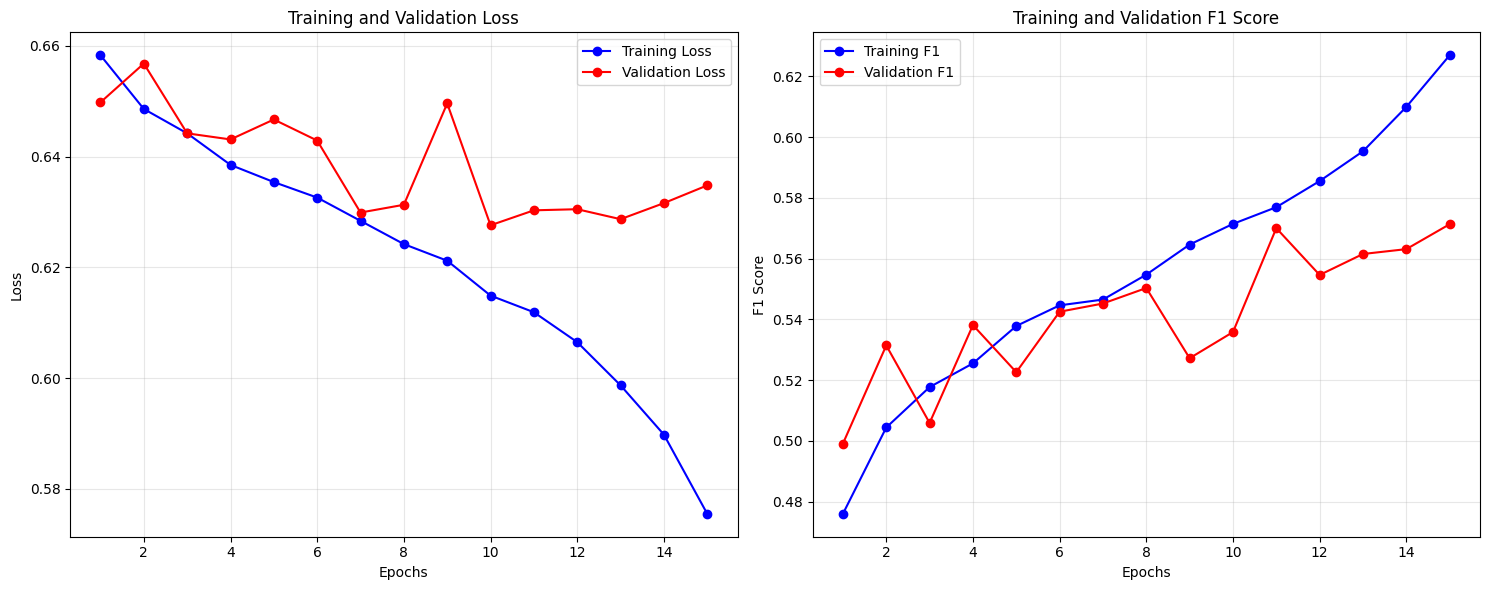

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a simple function to plot training history
def plot_training_metrics(train_loss, val_loss, train_f1, val_f1):
    """
    Simple function to plot training and validation metrics
    
    Args:
        train_loss: List of training loss values per epoch
        val_loss: List of validation loss values per epoch
        train_f1: List of training F1 scores per epoch
        val_f1: List of validation F1 scores per epoch
    """
    epochs = range(1, len(train_loss) + 1)
    
    # Create a figure with 2 subplots side by side
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Training and Validation F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1, 'b-o', label='Training F1')
    plt.plot(epochs, val_f1, 'r-o', label='Validation F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example data from your training results
train_loss = [0.6583, 0.6486, 0.6442, 0.6385, 0.6354, 0.6326, 0.6284, 0.6242, 0.6212, 0.6149, 0.6119, 0.6065, 0.5987, 0.5898, 0.5755]
val_loss = [0.6498, 0.6568, 0.6442, 0.6431, 0.6467, 0.6429, 0.6299, 0.6313, 0.6496, 0.6276, 0.6303, 0.6305, 0.6287, 0.6316, 0.6348]
train_f1 = [0.4760, 0.5044, 0.5177, 0.5255, 0.5378, 0.5446, 0.5465, 0.5547, 0.5646, 0.5714, 0.5769, 0.5855, 0.5953, 0.6099, 0.6269]
val_f1 = [0.4991, 0.5314, 0.5059, 0.5381, 0.5226, 0.5425, 0.5452, 0.5503, 0.5272, 0.5358, 0.5700, 0.5546, 0.5615, 0.5631, 0.5713]

# Plot the metrics
plot_training_metrics(train_loss, val_loss, train_f1, val_f1)

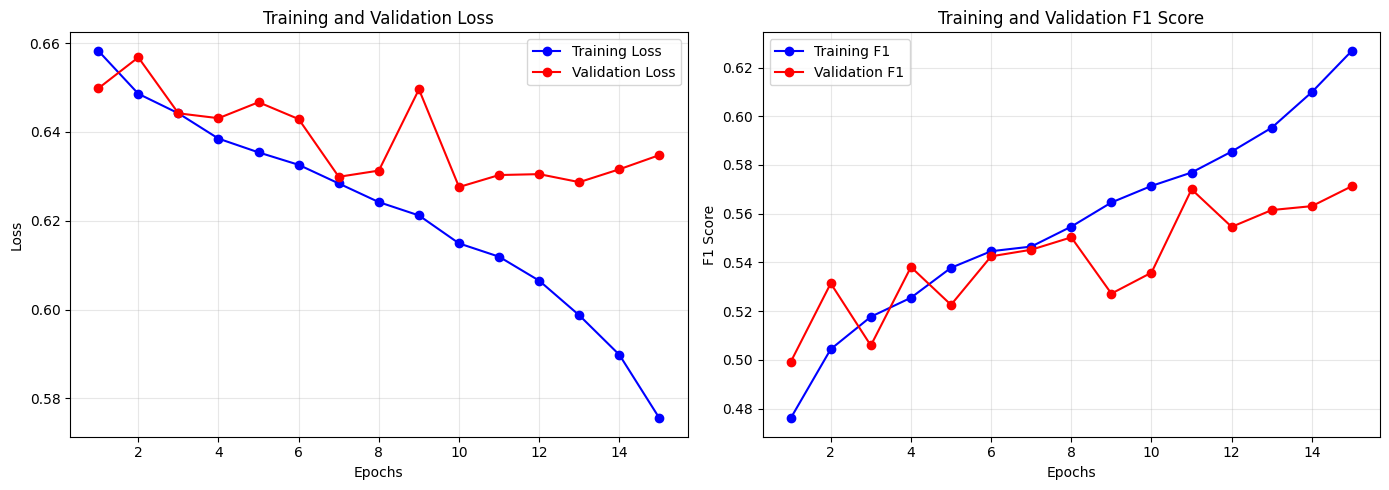

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    """
    Simple function to plot training and validation metrics
    
    Args:
        metrics_dict: Dictionary containing 'train_loss', 'val_loss', 
                     'train_f1', and 'val_f1' lists
    """
    epochs = range(1, len(metrics_dict['train_loss']) + 1)
    
    # Create a figure with 2 subplots
    plt.figure(figsize=(14, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_dict['train_loss'], 'b-', marker='o', label='Training Loss')
    plt.plot(epochs, metrics_dict['val_loss'], 'r-', marker='o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # F1 Score plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_dict['train_f1'], 'b-', marker='o', label='Training F1')
    plt.plot(epochs, metrics_dict['val_f1'], 'r-', marker='o', label='Validation F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Data from your training results
metrics = {
    'train_loss': [0.6583, 0.6486, 0.6442, 0.6385, 0.6354, 0.6326, 0.6284, 0.6242, 0.6212, 0.6149, 
                  0.6119, 0.6065, 0.5987, 0.5898, 0.5755],
    'val_loss': [0.6498, 0.6568, 0.6442, 0.6431, 0.6467, 0.6429, 0.6299, 0.6313, 0.6496, 0.6276, 
                0.6303, 0.6305, 0.6287, 0.6316, 0.6348],
    'train_f1': [0.4760, 0.5044, 0.5177, 0.5255, 0.5378, 0.5446, 0.5465, 0.5547, 0.5646, 0.5714, 
                0.5769, 0.5855, 0.5953, 0.6099, 0.6269],
    'val_f1': [0.4991, 0.5314, 0.5059, 0.5381, 0.5226, 0.5425, 0.5452, 0.5503, 0.5272, 0.5358, 
              0.5700, 0.5546, 0.5615, 0.5631, 0.5713]
}

# Generate the plots
plot_metrics(metrics)

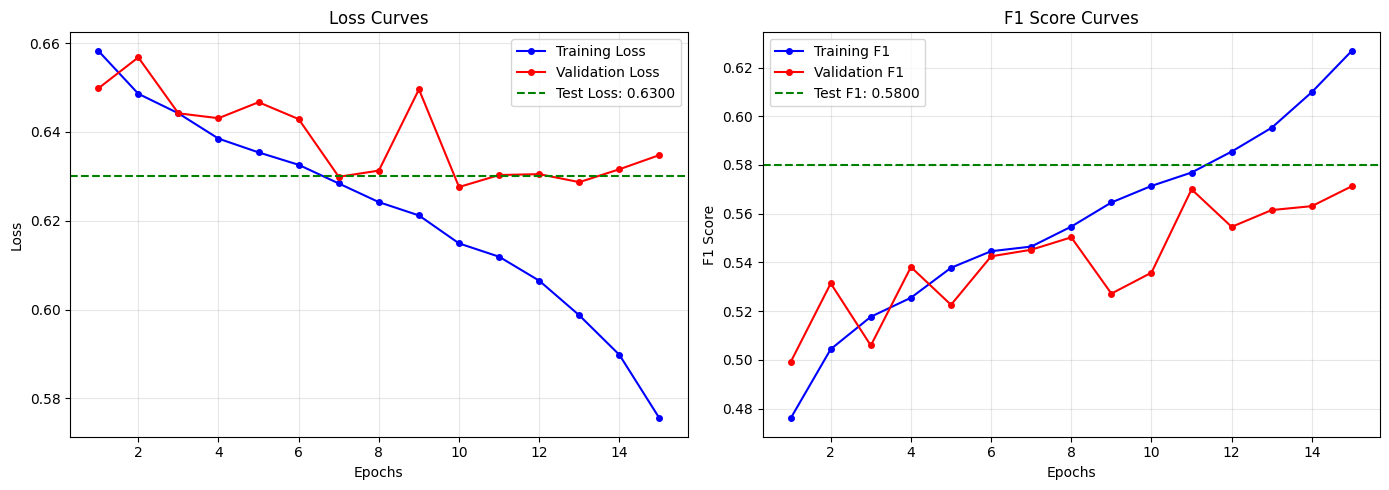

In [10]:
import matplotlib.pyplot as plt

# Training metrics data from your output
train_loss = [0.6583, 0.6486, 0.6442, 0.6385, 0.6354, 0.6326, 0.6284, 0.6242, 0.6212, 0.6149, 0.6119, 0.6065, 0.5987, 0.5898, 0.5755]
val_loss = [0.6498, 0.6568, 0.6442, 0.6431, 0.6467, 0.6429, 0.6299, 0.6313, 0.6496, 0.6276, 0.6303, 0.6305, 0.6287, 0.6316, 0.6348]
train_f1 = [0.4760, 0.5044, 0.5177, 0.5255, 0.5378, 0.5446, 0.5465, 0.5547, 0.5646, 0.5714, 0.5769, 0.5855, 0.5953, 0.6099, 0.6269]
val_f1 = [0.4991, 0.5314, 0.5059, 0.5381, 0.5226, 0.5425, 0.5452, 0.5503, 0.5272, 0.5358, 0.5700, 0.5546, 0.5615, 0.5631, 0.5713]

# Test metrics - replace these with your actual test results when available
test_loss = 0.63  # Example value
test_f1 = 0.58    # Example value

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Loss
epochs = range(1, len(train_loss) + 1)
ax1.plot(epochs, train_loss, 'b-o', markersize=4, label='Training Loss')
ax1.plot(epochs, val_loss, 'r-o', markersize=4, label='Validation Loss')
ax1.axhline(y=test_loss, color='g', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot for F1 Score
ax2.plot(epochs, train_f1, 'b-o', markersize=4, label='Training F1')
ax2.plot(epochs, val_f1, 'r-o', markersize=4, label='Validation F1')
ax2.axhline(y=test_f1, color='g', linestyle='--', label=f'Test F1: {test_f1:.4f}')
ax2.set_title('F1 Score Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()